In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns


from pathlib import Path

seed = 41# 424#0#424 #42
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.stats as stats

In [2]:
from matplotlib import animation


In [3]:
from ipywidgets import interact, fixed
from IPython.display import HTML, display


In [4]:
import seaborn as sns
ffmpeg_path = 'C://Users//thoma//Documents//ffmpeg//FFmpeg//bin'#//bin'

In [5]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("poster")
sns.set_style("ticks")
#sns.set_style("dark")
sns.despine()


<Figure size 720x720 with 0 Axes>

In [6]:
# for working with external files, otherwise kernels needs to be restarted each time
%load_ext autoreload
%autoreload 2


In [7]:
iters = 10
l2 = 1
n_std = 4
epochs = 300#500 is great#500#10000#1000
all_predictions = True
toy = True
decay = 0.005
non_linearity = torch.nn.Tanh#torch.nn.LeakyReLU#
showcase = True
if toy:
    epochs =500
    all_predictions = True
    decay = 0.0005
    #decay = 0.012875000000000001

    non_linearity = torch.nn.Tanh#torch.nn.LeakyReLU#

def get_fig_path(name):
    return f'figures\\toy_complex_figs\\complex_{name}.pdf'

In [8]:
from helpers import showcase_code

In [9]:
from data_loaders import get_X_y, generate_y
showcase_code('data_loaders.py',showcase=False)

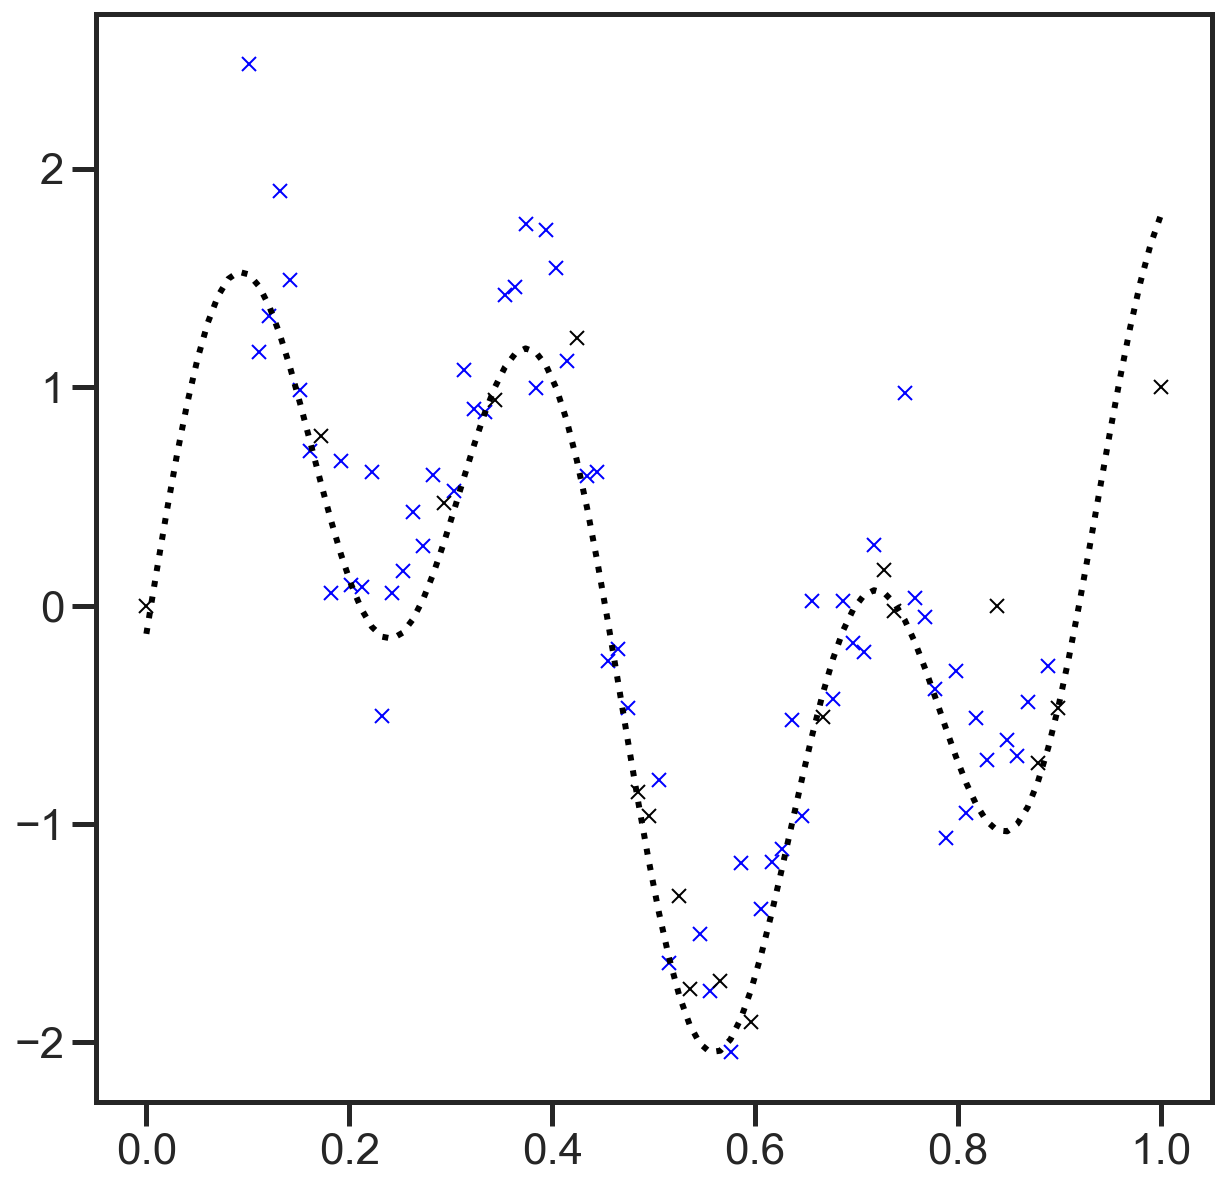

In [10]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed+3,out_of_sample=True,plot=True)#,fname=get_fig_path('toy_data'))

In [11]:
from helpers import plot_uncertainty, plot_generating_function, plot_mean_std
showcase_code('helpers.py',showcase=False)


C:\Users\thoma\Miniconda3\envs\pytorch\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


cobeau: (nan, nan)
nlpd: -1.0142753199218228.
 nlpds of just mean and just std of the model:
0.4373670920260526


C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\measures.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(x+0.0001)


nan
error: 0.22428983446330453


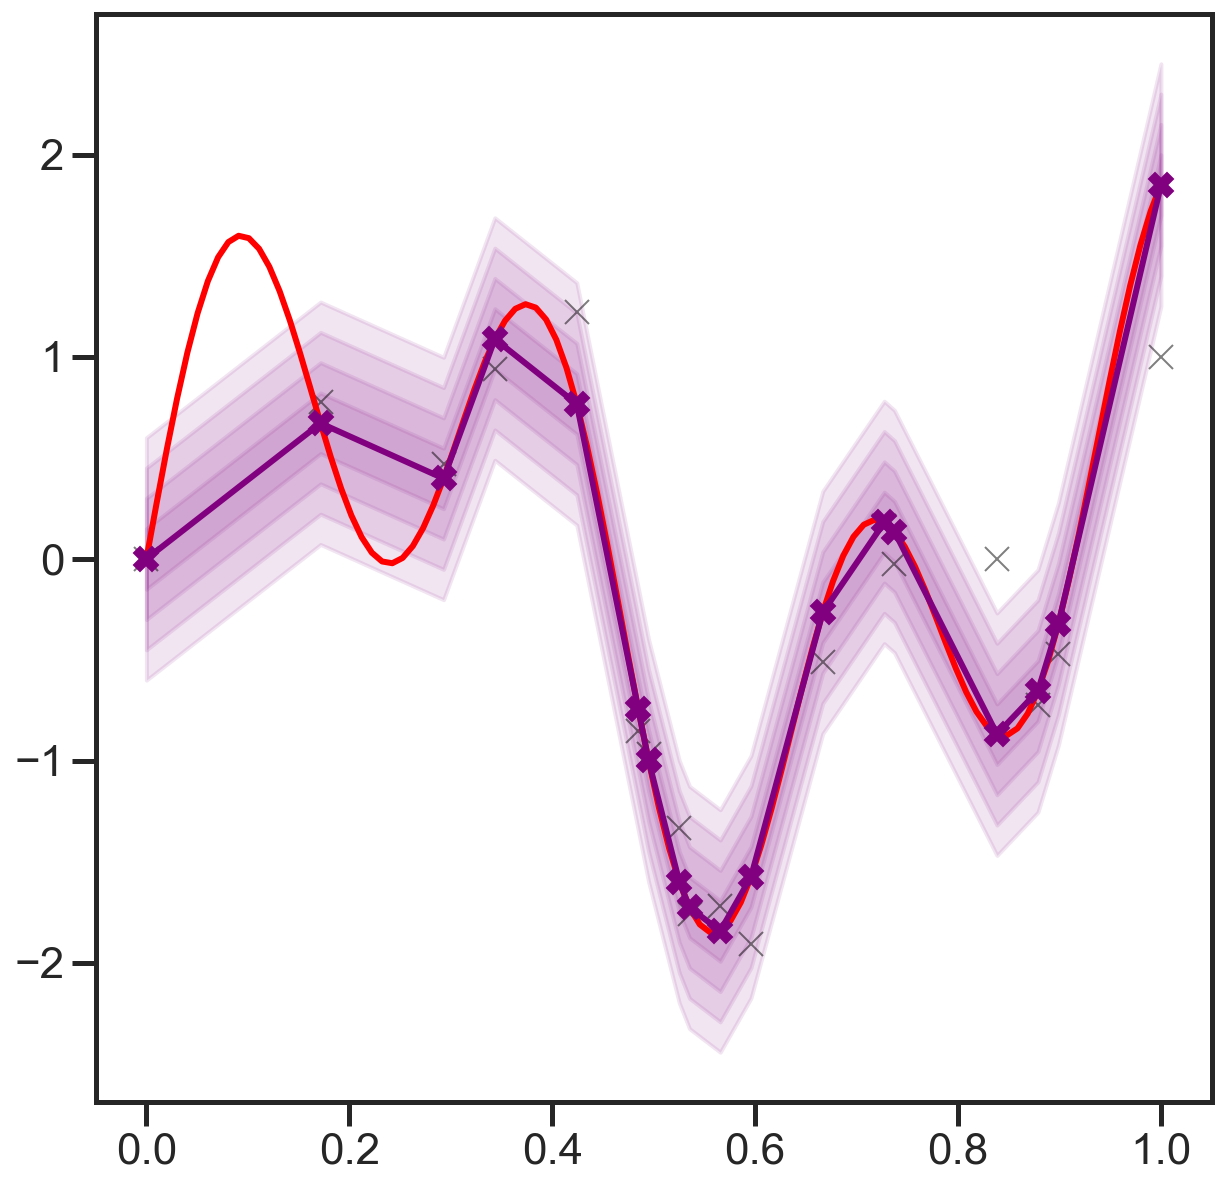

In [12]:
if toy:
    plot_generating_function(X_test,y_test,generate_y,0.3,N)

In [13]:
from nn_models.base_ensemble import VanillaEnsemble
showcase_code('nn_models/base_ensemble.py',showcase=True)

In [14]:
from nn_models.ensembles import BootstrapEnsemble
from nn_models.models import DropoutModel


In [15]:
class ReAnimator(object):
    def __init__(self,X_train,y_train,X_test,y_test,ensemble=None,generating_function = None):
        self.losses = []

        self.X_train = X_train
        self.y_train = y_train
        
        self.X_test = X_test
        self.y_test = y_test
        #self.X_true = X_true
        #self.y_true = y_true
        
        self.X_original = np.expand_dims(np.linspace(round(X_test.min()),round(X_test.max()),100),1)    

        
        self.ensemble = ensemble


        self.fig, self.ax0 = plt.subplots(1,1)
        self.ax0.set_ylim([-2,2])
        #self.ax0.plot(self.X_test, self.y_test, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
        self.ax0.plot(self.X_test, self.y_test, ls="none", marker="x", color="black", alpha=0.9, label="test")
        self.ax0.plot(self.X_train, self.y_train, ls="none", marker="x", color="blue", alpha=0.2, label="train")
        
        
        if generating_function is not None:
            self.ax0.plot(self.X_original, generating_function(self.X_original), ls=":", color="black", label="generating function")

        
        #self.ax0.plot(self.X_true, self.y_true, ls="-", color="r", label="true")
        self.ln_mean, = self.ax0.plot([], [], ls="-", color="purple", label="mean") 
        self.ln_pred, = self.ax0.plot([], [], ls='none', color="black", label="test set prediction",marker='X')

        self.n_std = n_std

        self.loss_text = self.ax0.set_title('', fontsize=15)
        self.fill_stds = []
        for i in range(n_std):
            fill_t = self.ax0.fill_between(
                [], [], [],
                color="b",
                alpha=0.5**(i+1)
            )
            self.fill_stds.append(fill_t)

        self.ax0.legend(loc="upper left")

    
    def init_plot(self):
        self.ln_mean.set_data([], [])
        self.loss_text.set_text('')
        return self.ln_mean, self.loss_text
    
    
    def animate_plot(self,i,iters=5):
        sort = True
        
        X_ = np.arange(len(self.X_test))
    
        if sort==True:
            index = np.argsort(self.X_test.squeeze())
        else: 
            #just use index [0,1,2,3,4,...]
            index = X_
        #print(index)
        
        for j in range(iters):
            loss = self.ensemble.fit_model(self.X_train,self.y_train)
            self.losses.append(loss)
            
        y_mean, y_std = self.ensemble.uncertainty_function(self.X_original, iters, l2=l2)
        y_mean_test, y_std_test = self.ensemble.uncertainty_function(self.X_test, iters, l2=l2)
        
        #y_mean = y_mean[index]
        #y_std = y_std[index]
        
        #print(y_mean[index])
        #print(self.X_test[index])
        
#         plt.plot(self.X_test[index], self.y_test[index], ls="none", marker="x", color="black", alpha=0.9, label="observed")
#         plt.plot(self.X_test, y_mean_test, ls='none', color="black", label="test set prediction",marker='X')
#         for i in range(n_std):
#             plt.fill_between(
#                 self.X_original.squeeze(),
#                 y_mean - y_std * ((i+1)/2),
#                 y_mean + y_std * ((i+1)/2),
#                 color="purple",
#                 alpha=0.1
#             )
        
        
#         self.ln_mean.set_data(self.X_test, y_mean_test)
#         #self.ln_mean.set_data(self.X_obs, y_mean)
#         for i in range(self.n_std):
#             self.fill_stds[i].remove()
#             self.fill_stds[i] = self.ax0.fill_between(
#                 self.X_test[index].squeeze(),
#                 y_mean[index] - y_std[index] * ((i+1)/2),
#                 y_mean[index] + y_std[index] * ((i+1)/2),
#                 color="b",
#                 alpha=0.5**(i+1)
#             )
        
        self.ln_mean.set_data(self.X_original, y_mean)
        self.ln_pred.set_data(self.X_test, y_mean_test)
        #self.ln_mean.set_data(self.X_obs, y_mean)
        for i in range(self.n_std):
            self.fill_stds[i].remove()
            self.fill_stds[i] = self.ax0.fill_between(
                self.X_original.squeeze().squeeze(),
                y_mean - y_std * ((i+1)/2),
                y_mean + y_std * ((i+1)/2),
                color="purple",
                alpha=0.1
            )
        return [self.ln_mean, self.loss_text] + self.fill_stds
    
    
    
    def train(self, iters, interval=100):
        anim = animation.FuncAnimation(
            self.fig, self.animate_plot, init_func=self.init_plot,
            frames=range(iters), interval=interval, blit=True)
        return HTML(anim.to_html5_video())

In [16]:
vanilla = VanillaEnsemble(toy,output_dims,non_linearity=non_linearity,decay=decay)
#vanilla = BootstrapEnsemble(toy,output_dims,dataset_lenght = len(X_train),non_linearity=non_linearity,decay=decay)
vanilla = DropoutModel(toy,output_dims,p=0.15,non_linearity=non_linearity,decay=decay)

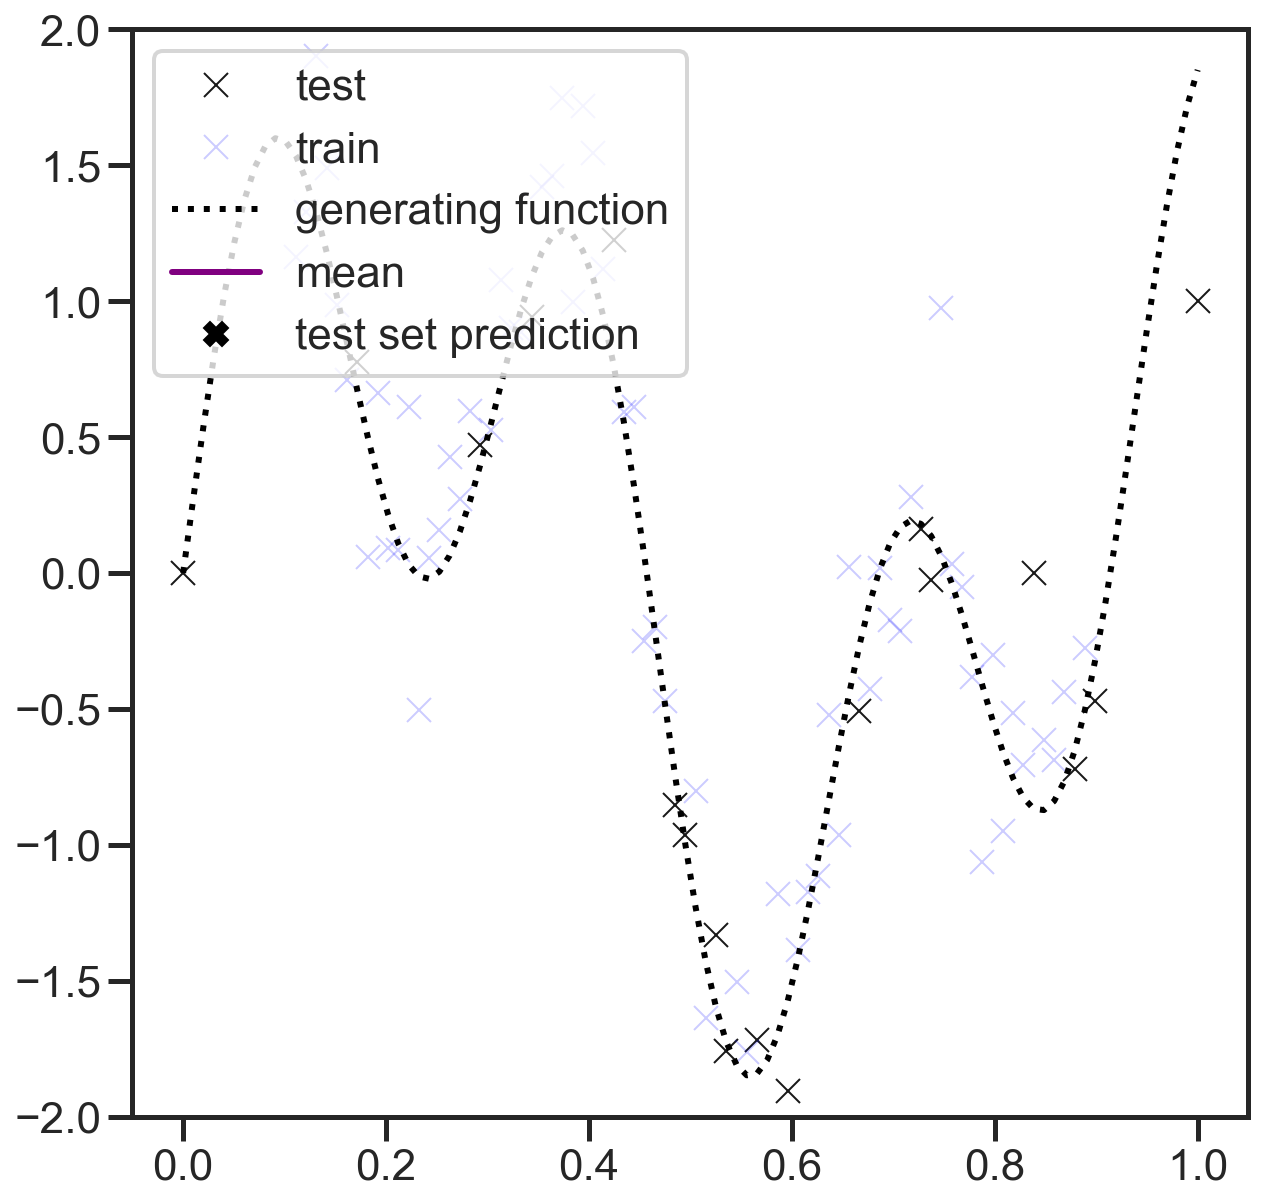

In [17]:
reanimator = ReAnimator(X_train,y_train,X_test,y_test,vanilla,generating_function=generate_y)

In [18]:
#plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=True,fname=get_fig_path('vanilla'),generating_function=generate_y)

In [19]:
#reanimator.animate_plot(10)

In [20]:
reanimator.train(100,interval=100)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.73it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.16it/s]


cobeau: (-0.11918039986124929, 0.6376235559809299)
nlpd: -0.9525701059205457.
 nlpds of just mean and just std of the model:
0.4373670920260526


C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\measures.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(x+0.0001)


nan
error: 0.39722808716487784


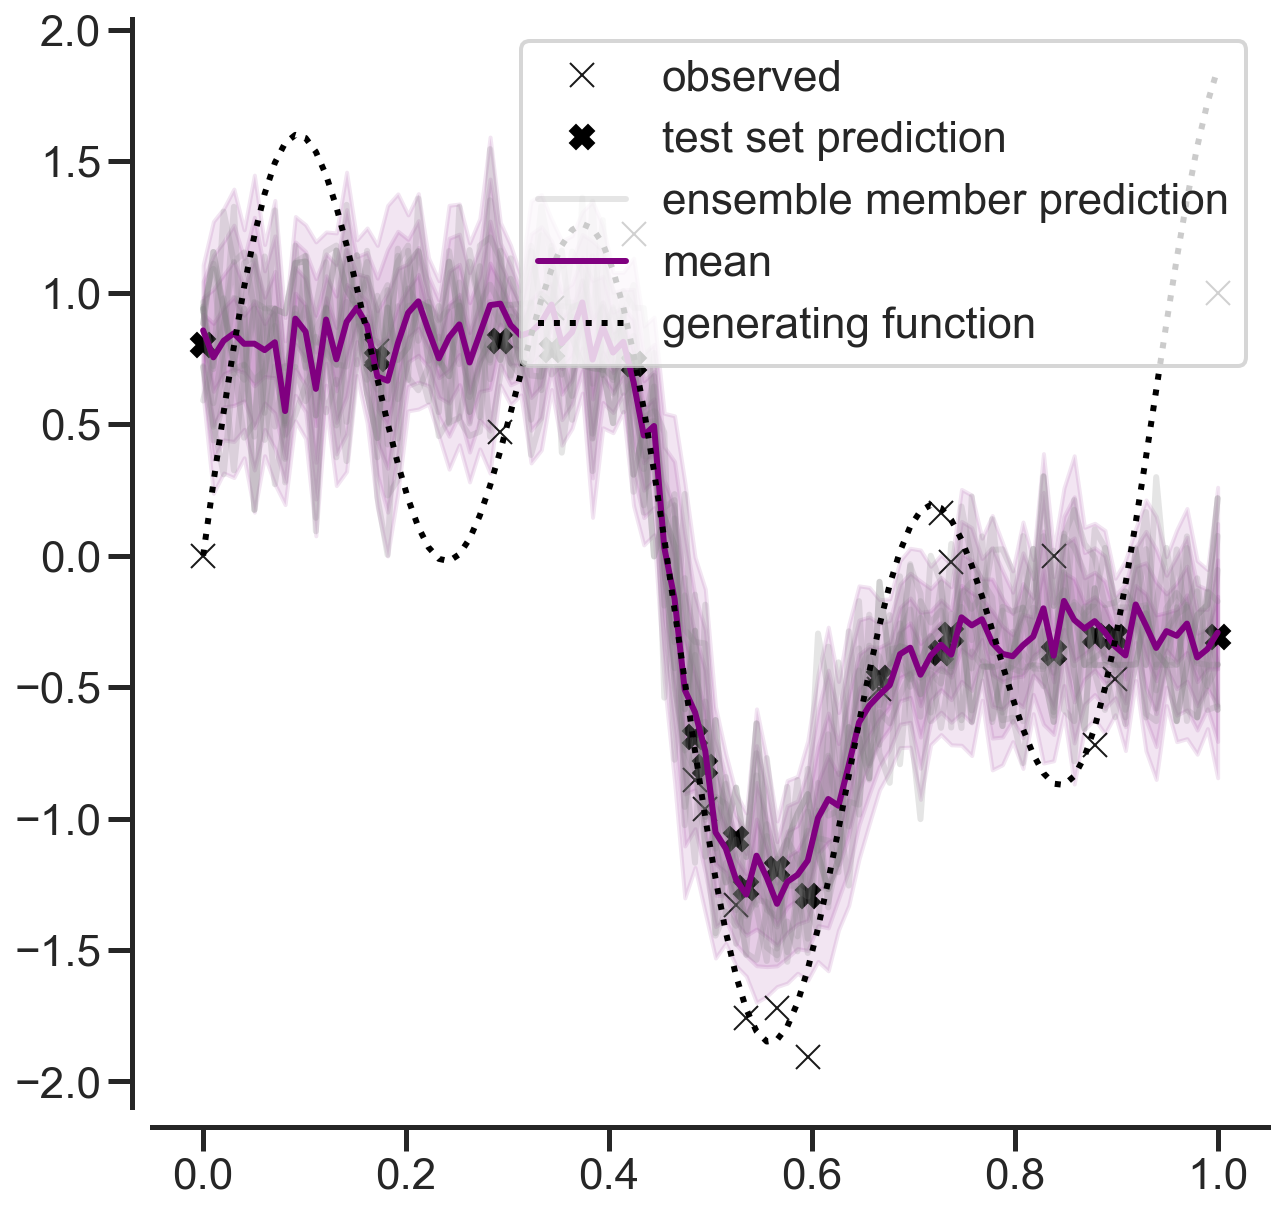

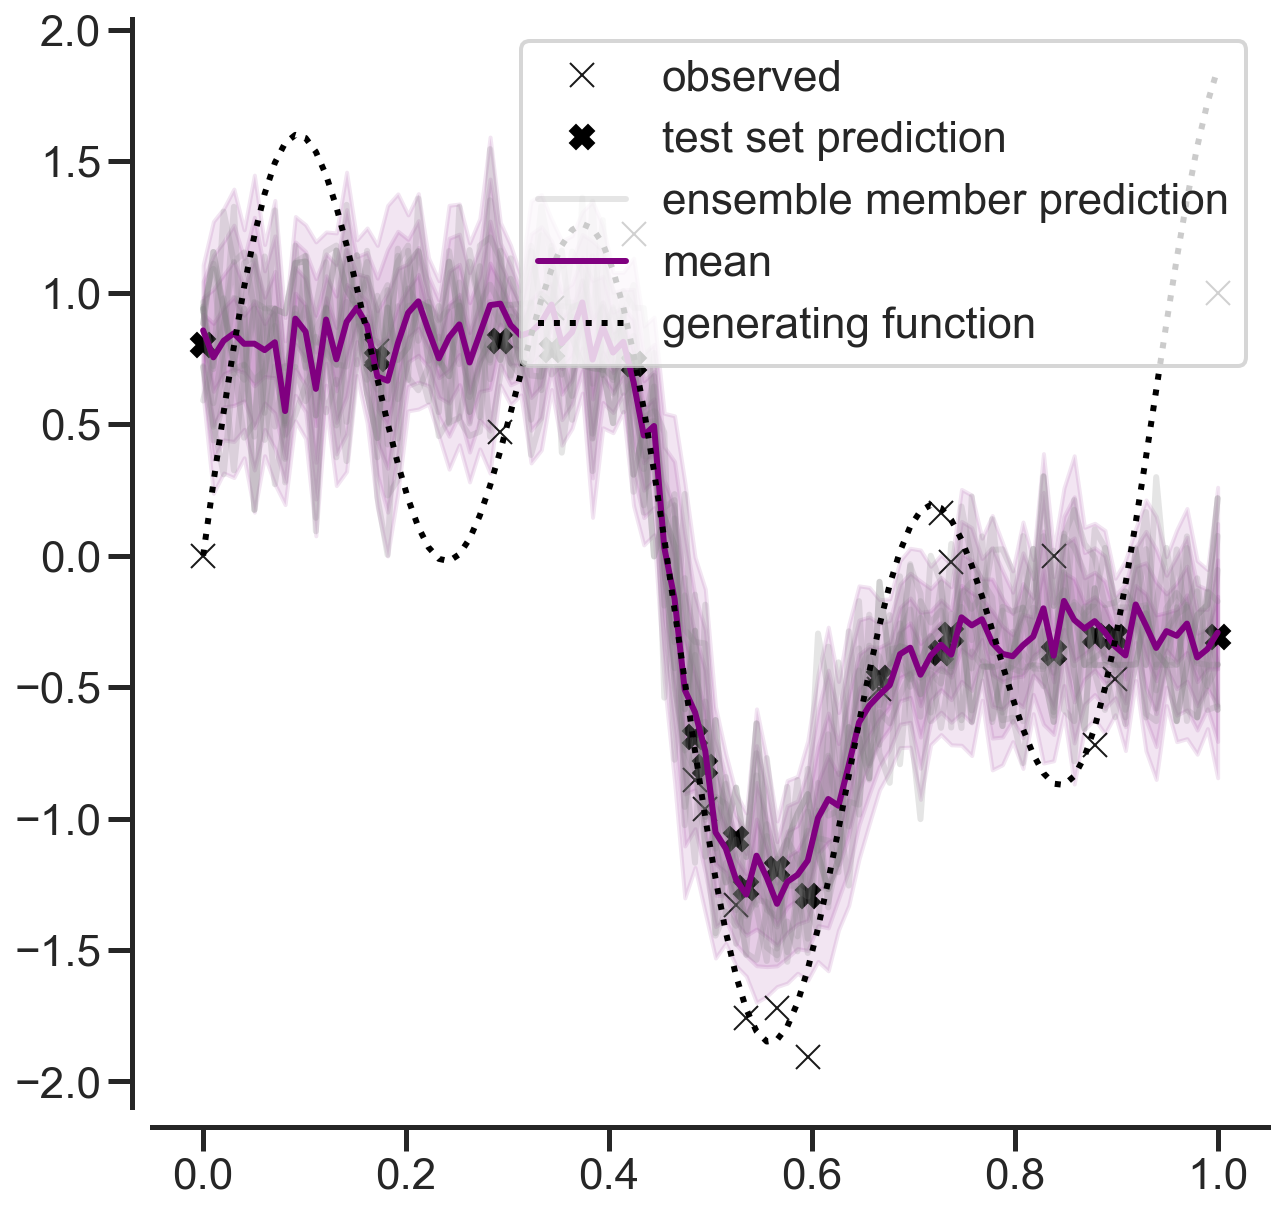

In [21]:
plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=True,generating_function=generate_y)